<a href="https://colab.research.google.com/github/jakhal/WikiArt-Art-Style-Recognition-Web-App/blob/main/ASaAI_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Art Style Recognition using Transfer Learning
==============================================
Projekt im Seminar: ASaAI (Adaptive Systems and Artificial Intelligence)

Code basiert auf: 
Transfer Learning for Computer Vision Tutorial von `Sasank Chilamkurthy <https://chsasank.github.io>` (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

Erweiterungen und Anpassungen von Jakob Halswick




Imports
---

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
%matplotlib inline

Mounting Google drive to access modified Wikiart Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Daten laden
---------



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation and test
img_size = 512
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        #transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/wikiart_ASaAI' # path to folder with modified Wikiart Dataset (70, 10, 10 Images per class, thus class-balanced, but small)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), # 
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(class_names)

['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism', 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance', 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e']


**Visualization of some images**



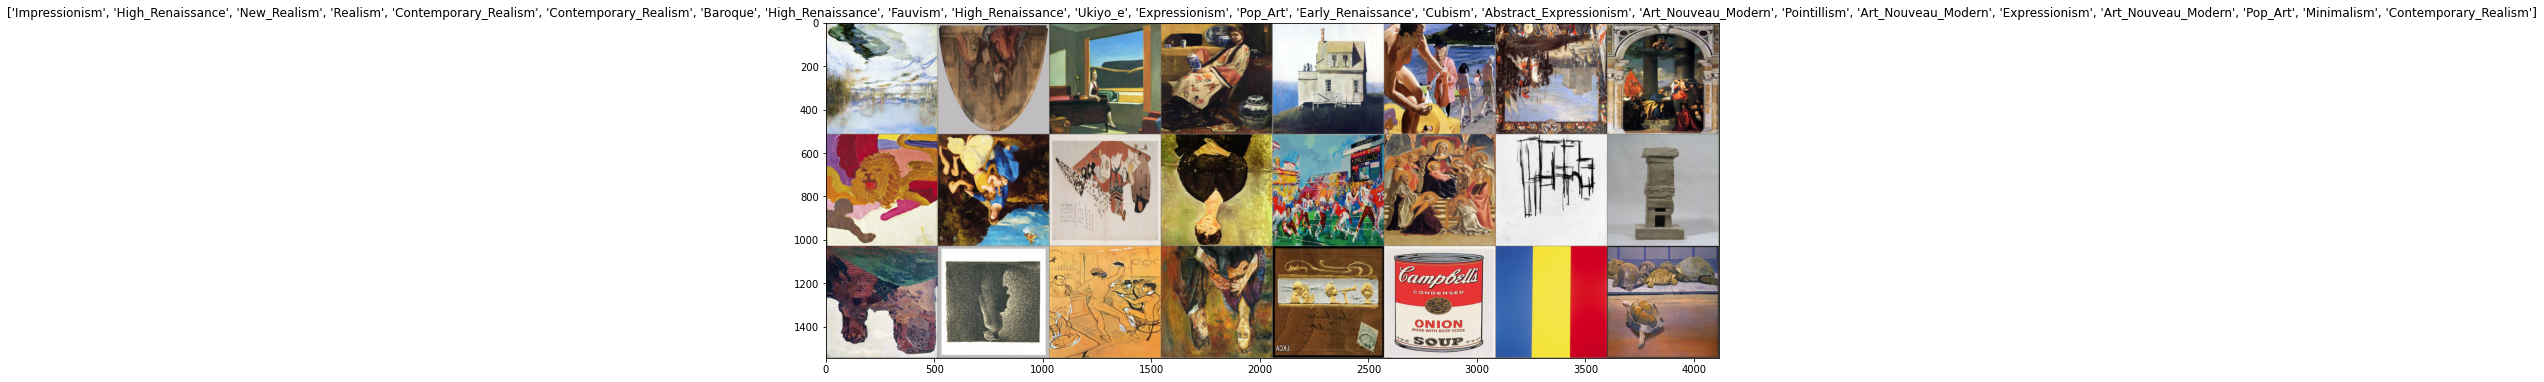

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------




In [ ]:
def train_model(model, criterion, optimizer, scheduler, epoch_in=0, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
  
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+epoch_in}/{num_epochs + epoch_in - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6): # based on tutorial code, modified to get Top3 Classes with Probabilities and the actual label
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1) * 100 #torch.softmax(outputs, 1) # calculate softmax of outputs to get probability of output
            top3 = torch.topk(outputs, 3)
            
            #print(outputs)
            #print(preds)
            #print(top3)
            sum_probs = torch.sum(probs)
            #print(f'Probs: {probs}')
            #print(f'Sum of Probs: {sum_probs}')
            #probs = torch.max(probs)
            #probs = probs.item()

            for j in range(inputs.size()[0]):
                #print(f'Probs of Image: {j}:  {probs[j]}')
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} actual: {class_names[labels[j]]} with Prob: {probs[j][preds[j]].item()} other possabilies: {class_names[top3[1][j][1].item()]} with Prob: {probs[j][top3[1][j][1]].item()} or {class_names[top3[1][j][2].item()]} with Prob: {probs[j][top3[1][j][1]].item()}')#{1:.2f}'.format((probs[j].item())))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    
                    return

        model.train(mode=was_training)

Test Internet Image from URL
---


In [ ]:
import urllib.request

def test_image(model, img_url): # author: Jakob Halswick

  urllib.request.urlretrieve(img_url, 'img_under_test.jpg')
  

  was_training = model.training
  model.eval()

  transform = transforms.Compose([
      transforms.Resize((img_size,img_size)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]) 

  img = Image.open('img_under_test.jpg')  # Load image as PIL.Image
  x = transform(img)                      # apply transformations
  x = x.unsqueeze(0)                      

  with torch.no_grad():

    x = x.to(device)
    
    output = model(x)
    pred = torch.argmax(output, 1)
    prob = torch.softmax(output, dim=1) * 100
    top3 = torch.topk(output, 3)
    
    print(f'Summe der Wahrscheinlichkeiten: {torch.sum(prob)}')

    imshow(x.cpu().data[0])
    print(class_names[pred])

    print('TOP3 Predictions:')
    print('-----------------')
    print(f'1: {class_names[top3[1][0][0].item()]} with Probability: {top3[0][0][0].item()} ')
    print(f'2: {class_names[top3[1][0][1].item()]} with Probability: {top3[0][0][1].item()} ')
    print(f'3: {class_names[top3[1][0][2].item()]} with Probability: {top3[0][0][2].item()} ')
  model.train(mode=was_training)







       

Finetuning
----------------------

*   Laden des vortrainierten Modells
*   Anpassung der letzen Schicht auf unsere 27 Klassen
*   Einrichtung der Trainingsparameter







In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

**Train and evaluate**


In [ ]:
 model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.9665 Acc: 0.1874
val Loss: 2.6032 Acc: 0.2536

Epoch 1/24
----------
train Loss: 2.5399 Acc: 0.2674
val Loss: 3.0004 Acc: 0.2250

Epoch 2/24
----------
train Loss: 2.1495 Acc: 0.3568
val Loss: 2.4604 Acc: 0.2964

Epoch 3/24
----------
train Loss: 1.9202 Acc: 0.4089
val Loss: 2.6694 Acc: 0.3464

Epoch 4/24
----------
train Loss: 1.8381 Acc: 0.4374
val Loss: 2.0607 Acc: 0.3643

Epoch 5/24
----------
train Loss: 1.6249 Acc: 0.4900
val Loss: 2.3486 Acc: 0.3500

Epoch 6/24
----------
train Loss: 1.5440 Acc: 0.5047
val Loss: 2.6132 Acc: 0.3071

Epoch 7/24
----------
train Loss: 1.0540 Acc: 0.6732
val Loss: 1.7311 Acc: 0.4786

Epoch 8/24
----------
train Loss: 0.7617 Acc: 0.7642
val Loss: 1.7528 Acc: 0.4750

Epoch 9/24
----------
train Loss: 0.5965 Acc: 0.8289
val Loss: 1.7432 Acc: 0.4893

Epoch 10/24
----------
train Loss: 0.5393 Acc: 0.8384
val Loss: 1.8291 Acc: 0.4857

Epoch 11/24
----------
train Loss: 0.4627 Acc: 0.8753
val Loss: 1.7868 Acc: 0.4821

Ep

Saving the Model
---

In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/wikiart_ASaAI/resnet50_512_transplus.pth')

Reload model
---

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/wikiart_ASaAI/resnet50_512_transplus.pth', map_location=device))
model_ft = model_ft.to(device)
model_ft.eval()


Saving and Reloading the whole Model to be able to continue training
===


Saving model parameters into checkpoint

In [ ]:
checkpoint = { 
    'epoch': 34,                    # save current epoch
    'model': model_ft,              # save model weights
    'optimizer': optimizer_ft,      # save state of optimizer
    'lr_sched': exp_lr_scheduler}   # save state of learning rate scheduler
torch.save(checkpoint, 'checkpoint_resnet50_512_imagenettrans.pth')

Reload checkpoint

In [ ]:
checkpoint = torch.load('checkpoint_resnet50_512_imagenettrans.pth')
epoch_ft = checkpoint['epoch']
model_ft = checkpoint['model']
optimizer_ft = checkpoint['optimizer']
exp_lr_scheduler = checkpoint['lr_sched']

Continue Training

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       epoch_in=epoch_ft, num_epochs=10)

Visualize Model
===

In [ ]:
visualize_model(model_ft)

Zu viel Inhalt. Sie können den gesamten Inhalt nur sehen, wenn Sie angemeldet sind.


Testing online image on the model

Summe der Wahrscheinlichkeiten: 99.99999237060547


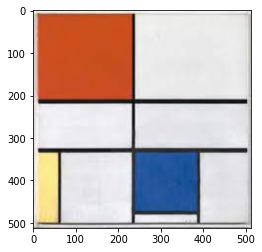

Minimalism
TOP3 Predictions:
-----------------
1: Minimalism with Probability: 7.647003650665283 
2: Color_Field_Painting with Probability: 7.606470584869385 
3: Abstract_Expressionism with Probability: 5.9495368003845215 


In [ ]:
test_image(model_ft, 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgVFRUYGBgYGBgYGBgYGBgYGBgYGBgZGhgYGBgcIS4lHB4rIRgYJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8PGBIRGDQhGCExNzQxNDQ0PzYxNDQ0MTUxPzQ0NDExNDE0NDQxNDQ0MTQxNDE0NDE0MTE0ND8xNDQxNP/AABEIAOIA3wMBIgACEQEDEQH/xAAcAAACAwEBAQEAAAAAAAAAAAAAAQIFBgcDBAj/xABKEAACAQECBgwKBwcFAQEAAAAAAQIDBBEFBiFUk9EHEhYxUlNxcpGSsdITFRciMkFRobLBFCQzNGFz4iMlNWJjgYNCRKKj8IJD/8QAGgEBAQEBAQEBAAAAAAAAAAAAAAEEBQMCBv/EACYRAQABAwMEAgMBAQAAAAAAAAABAgMEERRRITEzgTJSBRJxEyP/2gAMAwEAAhEDEQA/ANrjBjDOg04Qi1tpLzm/U99XFTu6qcTHrMeOK8z/ACS+Zkbjn3r1VFUxEuvi4tuu3FVUdWrePNXiYdMh7uqmT9hDrS1GTA8dzc5aYwbPDWPHypxMOswWPdTiI9aWoydwXDc3OTZWeGsePdTiIdZhu6qcRDry1GTuAm5ucmxs8Na8e58RDrvugse58RDrvumSAbm5ybKzw1m7mpxEOvLUG7qpxEOvJfIyYDc3OTY2eGgwnsj1KNNz+jwlc0rtvJb/AOO1N7Z6s5RjK6GVJ+v1q84TjUvq8ucvmd4sL/Zw5kfhRvsVVV0a1T1crMt027v60xpGj0U5+yPvG6k+DH3k0K492RDws+DHpY/Cz4MfeMEgI+EnwY+8TnLgx956CvAhtpcGPSx+ElwY9LHeDAXhJcGPSwdWXBj0sbACLqT4Melnn4SfBj1nqPYQHjKrPgw6WfDWtko3uUVlyea/Zy8pZSKnCu8uV9iCqLHBeYn/ADyMka7HCPmJ+ycl0tajInKyfJL9BheGCQMAM8tcAAQE1XQAABAAANAAmABVNjX93lyr5neLB9nDmR+FHB8avu8uVfM7tg/7OHMh8KOrieP24P5HzeofWhORFMHlNTAaYrxR3gAbYgC8AC8LxAMBXjALguGgYEJIq8KRyLlfYi0kVmFfRXK/kQZ/HBeZHnz97T+RkTYY4+gvzJdqMecrK8kv0OF4YAAIztgAAZNDUAAFQAK8LwhgABVNjU/q8uVfM7tg77KHMh8KOE41fd5csfmd2wc/2UOZD4UdTE8ftwfyHm9Q97gGgZqYSYAAAIaBgIAAAC8BgCG2K8AFIq8KvzVzn2Is5FZhX0Vzn2RJIoMcPRXPl2oyBr8cfRXPl2oyBy8nyS/QYPhgCvADM2BDEMBCY2ARECQgAEwBFiBUY1fd5csfmd1wf9nDmQ+FHCcafu8uWPzO72Bfs4cyHwo6mJ4/bhfkPN6h7AwEzSwneRvGK4AvFeAmgC8aYgSAY7wQMCSYEYkkBBsrcKvzVzn2Is5FXhXeXK+xCRQ45LzFz5dqMgbLHH0P8msxpy8nyS/QYPhgCYxMz6NgC8AGgAARJDAAC6FcAxFfKnxp+7y5Y/M7tYn5kOZH4UcJxoX1eXKvmd1sH2cOZH4UdPF8ftwvyHm9Q9x3AwNLCVw0gBMBXA0AAJoaQh3gDBAxXgFxJIiiSAhJFbhX0Vzn2Is5FXhX0Vzn2ICkxy9Dlm+1mNZrtkS0qlZ9u4trwqWRrJftvac0eMkOBLpRgv2aqq5mmOjtYmTaotxTVOkry8GUe6WHAl0oN0sOBLpWs8Nvc4aN5Z+y8Ao90sOBL3axbpYcCXSht7nBvLP2XoFFulhwJdKHukhwJdKG3ucLvbP2XgFFukhwJdKFukhwJdKG3ucG9s/ZfXgUDxlhwJdKDdNDgS6UNvc4N7Z+z3xqX1eXLH5ndLD6EOZH4UfnfDGGYVqbgotNtZW09439DZYpRjGP0ap5sUr9vDLcrjoWKZpo0mOrj5lym5d/amdY0dRBs5j5XaObVevAPK5Rzar14HsyOm3gcx8rdHNqvXgHlao5tV68AOnAcxWy1Szap14Elst0c2q9eAHTEBzJ7LlHNqvXgHlco5tV68NYHTRHMlstUc2q9aGsa2WaObVetADpyQ7jmK2WaObVetT1j8rdDNqvWp6wOmNFXhXeXK+xGHey3Qzar1oay5wPjFC30ZVY05wUajhdJxbvUISv831ecBqbZY6daEoVYQnHbp7WcVON6budzV158m5Ww5lZtDDullBtX875s9oyLCyplinYczs2hp90luXsOZ2fQ0+6XLFeVFO8V7Fmln0NPugsV7Fmdn0MO6XDFeQUzxasWaWfQ0+6J4t2PNLPoafdLkjcNBULFux5pZ9DT7pPc5Y81s+hp90ttqK4Cr3OWTNbPoYd0UsW7Jm1DRU+6W1wAc02WMEWelYdvSoUoS8LTW2jThGVzjO9baKT9nQa6z4uWPaxf0Sz+jHL4Gn7Fl9EzuzL/D/8tP4Zm3sy8yHMj8KArXi7Y80s+hp90juaseaWfQ0+6XLEUUzxasWaWbQ0+6G5mxZpZtDT7pbtggin3NWLNLPoafdB4s2PNLPoafdLlIdwNFG8WbFmln0NPui3MWHNLNoafdLxojcBSbl7Dmdm0NPugsVrDmdm0NPul5cAFMsWLDmdn0NPuj3L2DM7NoafdLgVwNFNLFew5pZ9DT7pCpYKVGO1pU6dOLk24whGCbuWVqK3y6aK7Cq81cuokqtorzXz/mz1hvEIrzXz9ZKKECaAaRFooGgSRH+5FkHokIgAHoDIoZQSItjZFIDB7M38P/zQ+GobezehDmR+FGL2X1fYLv60Pgma2xz21OD9sIPpiiD6XIiwAoLwvIjAleK8iAE9sLbCIsInth7YgmSQEosGJDcQqDK/CnorlLKSKzCe9/cki3u81v8An+bJpnz2m0whG+c4xW3eWTUVff7X/c+eGF7Px9LSQ1iFWV5Fnx+NbPx9LSQ1kVhaz8fS0kNYR9oj4fG1Dj6WkhrDxrZ+PpaSGsD7xNnw+NrPx9LSQ1ieGLNnFLSQ1gWCYytWGrNnFHSw1g8OWbOKOlhrAsryLZXeO7NnFHSw1kZYcs2c0dLDvAZfZdl9RX50Pgma2wQupwXshBf8UYPZRwlRq2WMIVYTl4WLuhOMncoTytRb9qNdZsOWZQivpFLJCP8A+kPUuUC2uArN0FlzijpYaxSxgsuc0dLDvFFqIqt0FmzmjpYd4ksP2XOaOlhrCarO4LiueHrNnNHSw1ieHbNnNHSQ1gWIit8fWbOKWkhrBYds2cUdJDWBYtklIrHh2zZxR0kO8Cw3Zs5o6WGsC1iz0iiqjhmzZxR0kNZJYes2c0dLDvAWW1KrDKyLl1Hp4+sucUdLDvHy2+106sU6c4TSbTcZKSTyZL098gWN2AI26zujKThdVU1JR229tlddk4RifJLHOno13jqVT0X+Mn2nkkc3Iv10VaUz0aKaYmOrmEtiKGcvRLvFBgrESNW2Wiyuq14CMJbfaJ7bbKP+m/J6R2+8wmL+TDFv/Lp9lM+8W9VXVMVTq+a6YpjoqfJHDOXd+Uu3bk1sRQzmWiXeOoREze8nMPJFDOXol3h+SOnnUtEu8dPQkvwA5ktiKnnUtFHvAtiOlnU9HHvHT4cg1yAc18lFP12mWjj3gWxRSzmejjrOloW1A4xjbiVCw0lVjVc3Kahc4KKyqTvvTfBM9CwJpPbe46jsrx+pw/CtD4KhzqnLzVyLsNWLbpqmf2jV4X6qqYjSXx+L1wvcgdgXCfQfamJM2be3wy/7V8vi8Xfze4j4t/m/4lgKSG2tcL/vXy+DxcuF7kP6AuF7kfXdlFeNtb4T/evl8rsEbvS9xf4sYlxtlHwvhdpdOUNqobbeUXfftlwire90nQtitX2Nt8dPsgZMq3TTMfrGjTYrqqidVY9i6K/3L0S7wvJbDOXo13jpbEZNHu5p5KY5y9Eu+S8lMc5ehXfOlRJhXMXsVRzp6Fd8vMCYtqxUpU1Nz29Rzbcdrd5sY3XXvgmxbK3Cu8v/AHsAtpyyf/Uu0giU1v8AOZFs4+X5JaKPiTMLgD+M29f06fZTN2zCYAX75t35UOykfeF85/iXPi3kUSUSCkSTOrDwNRBxI7YFIolFEoxIxZJsCVwKIXiTCSxGyz9zj+dD4ZnN4RyHR9li76JH86n8EznEd424fepmyO0BogejIpG9jmCgxtiuC8KGjz9ZOUiPrD5NHRdit/U5L+tP3xhrOdo6FsVfdZr2V5/BB/Mw5nen22Y3aW6uItEpM85GFrNEjzvJRAleVmFnkXLqLJlXhXeRBcz3nzn8zyvPWo8jX8zPBHHy/JLTR8U2zC4vfxm3P+nDspG4Zh8XF++bfzKfZTPTB+U/x83e0N4wQXCuOo8DaCKIyeUEB6esZ5p5T0RRIigvBAYjZZl9Uiv60PgqHN47y5EdI2WJfVY/nQ+GZzaEsi/sbcPvUyZPaHogTAcTczPNod2QlcQkEQnHLkCROQpFTR573vOi7FMbrLN+2vP3Qhf8jnk4nRdix/VJr+vP3wgYM3vT7a8XtLbMQ7xNmJrJIlcJDYA0VeFFvFpeVuFfV/72EFvVWSXOZ4nvV9fK2fOmcfLj/pLVb+JSZisXP4xb/wAun2UzayMTi0/3vbvy6fZTPbC+U/x83u0N6gYJkl+J0md5tEsiPTaq4NogPJPKeiYnBXkozKmpXBcz0THcFc/2VvusPzofDM5zBZOg6Tsuyus1Ne2tH3Qmc2j6jbh95ZMntD0iySZ53EjdqywbIEkAiSUR7USWUe2GoU1kfIdE2KIfVZv215/BTOeTXYdF2KJXWSf50/ggYMzvDXjdpbWUCLR6OV55yMbUVw7hXgQDRXYU3lyvsRYNlZhPeXK/kBcV5+l+D1ngvUfBhe21ISahTdRylvbaMbkn7WVjwzaU8tgqv1ZJ0+m/bHMyLNdVczTHRooqpinrLQylkZh8XH+9bdzKXZDUWs8MWlq7xfX6YPsZSYGpWmla7RaZ2OvdVjBRjGMW04pJ35fw9R64tuqiZmqEuVRMdHQoHrdvGcWH6i37FaepHWSWMNTMrV1FrN2rwaKDDbGf3Q1MytPUjrIboqmZWrqR1gaPbApGdeMNTMbV1Y6x7oKuY2nqx1gaNe09EzMrGCrmNp6sdZPdFWzG0f8ADWBSbMEkrJCXsrR+CZUQ2Km0n9KWVX/ZfrPtx3harfQVKFkqwaqKe2mk1coyjdcn/N7jSww3XX+xr9MF8yoyHkpnnS0X6w8lMs7Wh/WbHdBXzCv0w1j8eWjMK3Wp6xqaMU9iyWdf9X6xPYslnX/V+s2nju05hV60NYvHVozCr1oaxqaMb5LHnP8A1frFLYul6rV00v1mzlhy0ZhV68NZ5PDNpv8AuNVJX3rbQy372W/J6xqaMhPYwmot/Sr2k3d4P2fjty22KH9Uk7t+tP4KZaTwtaXHa/Q619zTd8Mt/wDf2ZCoxNpWmxUHSnZKs5beU04uF1zUVdle/kZNdTRvdsebZSSwxaMxr9MH8xeN7RmNbph3hqq7Bsonhi0ZjW6YaweGK+Y1+mGsgupSKzCUsiu9r7InzrClof8Asqq5ZU9ZGrKrNK+lOL/HLv3esCmwja6nhpefPJOV3nPJlZ6UbbVu+0n1pawAj6e302rd9pP1/wCqWslC21eMn1pawAqScrZU4yfWlrIfTKl/2k+tLWABDjbavGT60tYvptXjJ9aWsAAUrbV4yfWlrIVLfVvX7Wp6/wDXLWICiLt9XjanXlrPnqYSr8dU68tYAUQ8Z1+Oqb3GS1kamE6/HVNJLWIAkvLxrX4+rpJ6xPC1o4+rpJ6wAiovC1o4+rpJ6yPjW0cfV0k9YwJPZRHC1o4+rpJ6yUsK1+Pq6SesAIkPNYUr8fV0k9Y1ha0cfV0k9YAVXtHCte/7erpJ6z08Z1+OqaSWsACB4Tr8dU0ktZGWE6/HVNJLWAEWEJYTr8dU0ktZY2C3VWpX1Zve35yfzABBL//Z')

Confusion Matrix
----
Analysing the models performance


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

data_dir = '/content/drive/MyDrive/wikiart_ASaAI/wikiart_ASaAI_test/test' # path to folder with bigger test dataset (90 images / class)
image_dataset = datasets.ImageFolder(data_dir,
                                          data_transforms['test'])
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=24,
                                             shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def confusion_m(model):

  y_pred = []
  y_true = []

  model.eval()
  fig = plt.figure()

  with torch.no_grad():
      for i, (inputs, labels) in enumerate(dataloader):#s):['test']): uncomment & 
          inputs = inputs.to(device)
          labels = labels.to(device)

          output   = model(inputs)
          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
      
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

      model.train()

  # constant for classes
  classes = class_names

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * len(class_names), index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (24,14))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('confusion_matrix.png')

<Figure size 432x288 with 0 Axes>

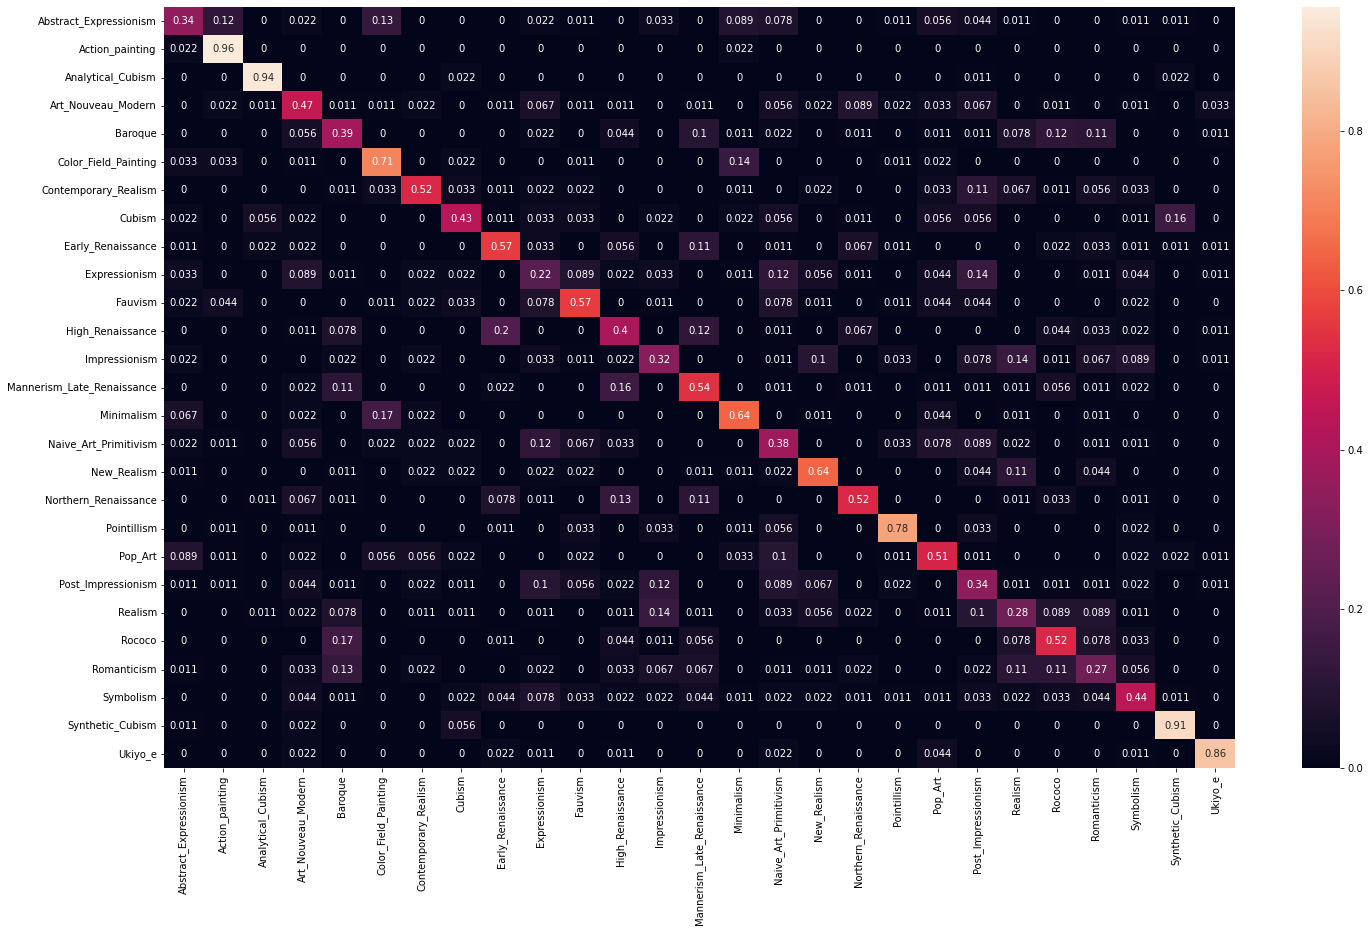

In [ ]:
confusion_m(model_ft)

Exporting the Model in ONNX format
---
source: https://docs.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-convert-model

In [ ]:
import torch.onnx

In [ ]:
#Function to Convert to ONNX 
def Convert_ONNX(model): 
    
    # set the model to inference mode 
    model.eval() 
    model.cpu()
    # Let's create a dummy input tensor  
    dummy_input = dummy_input = torch.randn(1, 3, 512, 512,requires_grad=True)  

    # Export the model   
    torch.onnx.export(model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         "/content/drive/MyDrive/wikiart_ASaAI/ImageClassifier_resnet50_512_wikiart.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=10,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['modelInput'],   # the model's input names 
         output_names = ['modelOutput'], # the model's output names 
         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                                'modelOutput' : {0 : 'batch_size'}}) 
    print(" ") 
    print('Model has been converted to ONNX')
    model.train()




In [ ]:
Convert_ONNX(model_ft)

 
Model has been converted to ONNX


Feature extraction
----------------------------------


In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters(): # freezes all layers
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

NameError: ignored

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()